In [67]:
from tqdm import tqdm
from array_lib import *
from point3d_lib import Point
from skeleton3d_lib import Skeleton
from IPython.display import display, clear_output
from skimage.morphology import skeletonize
from ply_creation_lib import create_ply, create_ply_normals
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pydicom as dicom
import numpy as np
import pickle
import ipympl
import time
import copy
import os

In [68]:
def read_dicom(input_folder: str) -> np.ndarray:
    files: list[str] = os.listdir(input_folder)
    data = [dicom.dcmread(f'{input_folder}\\{file}') for file in files if file.endswith('.dcm')]
    image = np.array([dicom.pixel_array(datum) for datum in data])
    return image

def fit_plane_first_last(skeleton: np.ndarray):
    middle_point = skeleton[len(skeleton)//2]
    first_point = skeleton[0]
    last_point = skeleton[-1]
    
    vector1 = first_point - middle_point
    vector2 = last_point - middle_point
    normal = np.cross(vector1, vector2)
    return normal / np.linalg.norm(normal)

def get_flow_vector(skeleton: np.ndarray):
    middle_point_id = len(skeleton)//2
    flow_vector = skeleton[middle_point_id+1] - skeleton[middle_point_id-1]
    return flow_vector / np.linalg.norm(flow_vector)

def project_vector(n: np.ndarray, v: np.ndarray):
    projected = v - (np.dot(v, n) / np.dot(n, n) * n)
    return projected / np.linalg.norm(projected)

def rotate_vector(f: np.ndarray, n: np.ndarray, degrees: float):
    rad_angle = np.radians(degrees)
    
    add1 = n * np.cos(rad_angle)
    add2 = np.cross(f, n) * np.sin(rad_angle)
    add3 = np.dot(f, n) * (1 - np.cos(rad_angle)) * f
    return add1 + add2 + add3

def draw_wireframe(ax, normal: np.ndarray):
    x = np.linspace(-100, 101, 3)
    y = np.linspace(-100, 101, 3)
    x, y = np.meshgrid(x, y)
    z = -(normal[0] * x + normal[1] * y) / normal[2]
    
    ax.plot_wireframe(x, y, z)
    
def draw_surface(ax, normal: np.ndarray):
    x = np.linspace(-200, 201, 2)
    y = np.linspace(-200, 201, 2)
    x, y = np.meshgrid(x, y)
    z = -(normal[0] * x + normal[1] * y) / normal[2]
    
    ax.plot_surface(x, y, z, color='0')
    
def normalize_image_colors(image: np.ndarray) -> np.ndarray:
    image = copy.deepcopy(image)
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val) * 255
    return image
    
def project_point(plane: np.ndarray, point: np.ndarray):
    return point - np.dot(point, plane) * plane

def get_84_rca_data():
    input_folder = f'{os.getcwd()}\\20240923_84'
    skeleton = np.array([(166, 250, 221), (167, 250, 220), (168, 250, 219), (169, 250, 218), (170, 250, 217), (171, 250, 216), (172, 250, 215), (173, 250, 214), (172, 250, 213), (171, 249, 212), (170, 249, 211), (170, 249, 210), (170, 248, 209), (169, 247, 209), (168, 247, 208), (167, 246, 207), (167, 246, 206), (166, 245, 205), (165, 244, 204), (164, 244, 203), (163, 243, 202), (162, 243, 202), (161, 242, 201), (160, 242, 201), (159, 242, 200), (158, 241, 199), (157, 241, 198), (156, 240, 198), (155, 240, 197), (154, 240, 197), (153, 240, 196), (152, 240, 195), (151, 240, 195), (150, 240, 194), (149, 239, 194), (148, 239, 193), (147, 239, 193), (146, 238, 192), (145, 238, 191), (144, 238, 190), (143, 238, 189), (142, 237, 189), (141, 237, 188), (140, 236, 187), (139, 235, 186), (139, 235, 185), (138, 234, 184), (138, 234, 183), (137, 233, 182), (138, 233, 181), (138, 232, 180), (137, 231, 180), (137, 230, 179), (138, 230, 178), (138, 229, 177), (138, 228, 176), (138, 227, 175), (139, 226, 174), (139, 225, 173), (140, 224, 173), (141, 223, 172), (142, 223, 171), (143, 222, 171), (144, 222, 171), (145, 221, 170), (146, 220, 169), (147, 219, 168), (148, 219, 168), (149, 219, 168), (150, 218, 167), (151, 217, 166), (152, 216, 166), (153, 216, 166), (154, 215, 165), (155, 215, 165), (156, 215, 165), (157, 214, 164), (158, 213, 163), (159, 213, 163), (160, 212, 162), (161, 211, 162), (162, 211, 162), (163, 210, 161), (164, 211, 161), (165, 210, 160), (166, 210, 160), (167, 209, 159), (167, 208, 159), (168, 207, 158), (169, 207, 158), (170, 207, 158), (171, 206, 157), (172, 205, 156), (173, 204, 155), (174, 204, 155), (175, 203, 154), (176, 202, 154), (177, 201, 154), (178, 200, 153), (179, 200, 153), (180, 200, 153), (181, 200, 153), (182, 199, 152), (183, 199, 152), (184, 198, 151), (185, 197, 151), (186, 196, 150), (187, 196, 149), (188, 195, 149), (189, 194, 148), (190, 193, 147), (191, 193, 146), (192, 192, 146), (193, 191, 145), (194, 190, 144), (195, 189, 144), (196, 188, 143), (196, 188, 142), (197, 187, 141), (198, 187, 141), (199, 187, 140), (200, 186, 140), (201, 185, 139), (202, 185, 138), (203, 184, 138), (204, 184, 138), (205, 183, 137), (206, 183, 137), (207, 183, 137), (208, 183, 137), (209, 182, 137), (210, 182, 137), (211, 181, 136), (212, 181, 136), (213, 180, 135), (214, 180, 135), (215, 180, 135), (216, 180, 135), (217, 179, 134), (218, 179, 134), (219, 179, 134), (220, 179, 134), (221, 179, 134), (222, 179, 134), (223, 179, 134), (224, 179, 133), (225, 179, 134), (226, 179, 134), (227, 178, 133), (228, 178, 133), (229, 178, 134), (230, 178, 133), (231, 178, 134), (232, 179, 134), (233, 179, 134), (234, 179, 134), (235, 179, 134), (236, 180, 134), (237, 180, 133), (238, 180, 133), (239, 180, 134), (240, 180, 133), (241, 181, 134), (242, 181, 133), (243, 181, 133), (244, 181, 134), (245, 181, 133), (246, 182, 134), (247, 182, 134), (248, 183, 135), (249, 183, 135), (250, 184, 135), (251, 184, 136), (252, 184, 136), (253, 184, 136), (254, 184, 136), (255, 184, 136), (256, 185, 136), (257, 186, 137), (258, 186, 137), (259, 186, 137), (260, 186, 138), (261, 187, 139), (262, 187, 140), (263, 187, 140), (264, 187, 140), (265, 187, 140)])
    return input_folder, skeleton

def get_84_lad_data():
    input_folder = f'{os.getcwd()}\\20240923_84'
    skeleton = np.array([(123, 325, 234), (124, 326, 234), (125, 327, 234), (125, 328, 235), (126, 329, 235), (126, 330, 235), (127, 331, 235), (127, 332, 235), (128, 333, 235), (128, 334, 235), (129, 335, 235), (128, 336, 236), (127, 337, 237), (127, 338, 238), (126, 338, 239), (125, 338, 240), (125, 339, 241), (125, 339, 242), (124, 340, 243), (123, 340, 244), (122, 341, 245), (122, 341, 246), (122, 341, 247), (122, 341, 248), (121, 341, 249), (120, 341, 250), (120, 341, 251), (120, 342, 252), (120, 341, 253), (119, 341, 254), (119, 341, 255), (119, 341, 256), (119, 341, 257), (119, 341, 258), (118, 341, 259), (117, 342, 260), (117, 341, 261), (116, 341, 262), (116, 341, 263), (117, 341, 264), (116, 341, 265), (115, 340, 265), (114, 340, 266), (113, 340, 266), (112, 339, 267), (111, 339, 268), (111, 339, 269), (111, 338, 270), (110, 338, 271), (109, 337, 272), (109, 337, 273), (108, 336, 274), (108, 336, 275), (107, 335, 276), (107, 334, 277), (107, 334, 278), (106, 333, 279), (107, 332, 280), (107, 331, 281), (107, 331, 282), (107, 330, 283), (108, 329, 284), (107, 329, 285), (107, 328, 286), (106, 327, 287), (106, 327, 288), (106, 326, 289), (106, 325, 290), (105, 324, 291), (105, 324, 292), (105, 323, 293), (104, 323, 294), (104, 322, 295), (104, 321, 296), (103, 320, 297), (103, 319, 298), (103, 319, 299), (103, 318, 300), (103, 317, 301), (102, 316, 302), (102, 315, 303), (101, 315, 304), (101, 314, 305), (101, 313, 306), (101, 312, 307), (100, 311, 308), (100, 310, 309), (99, 309, 310), (98, 308, 311), (97, 307, 312), (97, 306, 313), (97, 305, 314), (97, 304, 315), (96, 303, 315), (95, 302, 316), (95, 301, 317), (95, 300, 318), (95, 299, 319), (94, 298, 319), (94, 297, 320), (94, 296, 321), (93, 295, 321), (92, 295, 322), (93, 294, 321), (93, 293, 321), (92, 292, 322), (92, 291, 322), (92, 290, 322), (92, 289, 322), (92, 288, 322), (93, 287, 323), (92, 286, 323), (92, 285, 323), (92, 284, 323), (92, 283, 323), (92, 282, 323), (92, 281, 323), (92, 280, 323), (93, 279, 323), (94, 278, 323), (94, 277, 322), (94, 276, 322), (94, 275, 322), (95, 274, 322), (95, 273, 323), (95, 272, 323), (96, 271, 323), (97, 270, 323), (97, 269, 323), (97, 268, 323), (97, 267, 323), (98, 266, 323), (98, 265, 323), (99, 264, 323), (100, 263, 323), (101, 262, 323), (101, 261, 323), (102, 260, 323), (103, 259, 323), (104, 258, 323), (105, 257, 323), (105, 256, 323), (106, 255, 322), (107, 254, 322), (108, 253, 322), (109, 252, 322), (109, 251, 321), (110, 250, 321), (111, 250, 321), (112, 249, 321), (113, 248, 321), (114, 247, 320), (115, 246, 320), (116, 245, 320), (116, 244, 320), (117, 243, 320), (118, 242, 320), (118, 241, 320), (119, 240, 320), (120, 239, 320), (121, 238, 319), (122, 237, 319), (122, 236, 320), (123, 235, 320), (124, 234, 320), (124, 233, 320), (125, 232, 320), (126, 231, 320), (126, 230, 320), (127, 229, 320), (127, 228, 321), (127, 227, 321), (127, 226, 322), (127, 225, 322), (127, 224, 323), (127, 223, 323), (128, 222, 324), (128, 221, 324), (128, 220, 324), (128, 219, 324), (129, 218, 324), (129, 217, 325), (128, 216, 325), (128, 215, 326), (128, 214, 326), (128, 213, 327), (129, 212, 327), (129, 211, 328), (129, 210, 328), (129, 209, 329), (129, 208, 329), (130, 207, 329), (130, 206, 330), (130, 205, 330), (129, 204, 331), (129, 203, 331), (130, 202, 332), (129, 201, 332), (129, 200, 332), (130, 199, 332), (130, 198, 332), (130, 197, 333), (130, 196, 334), (130, 195, 335), (131, 194, 335), (132, 193, 335), (133, 192, 335), (133, 191, 336), (133, 190, 337), (134, 189, 337), (135, 188, 336), (136, 187, 337), (137, 186, 336), (138, 185, 336), (139, 184, 336), (140, 183, 336), (141, 183, 336), (142, 182, 336), (143, 181, 336), (144, 180, 335), (145, 180, 335), (146, 179, 335), (147, 179, 335), (148, 178, 335), (149, 178, 335), (150, 178, 335), (151, 177, 335), (152, 176, 335), (153, 175, 335), (154, 174, 335), (155, 173, 334), (156, 172, 334), (157, 172, 334), (158, 171, 334), (159, 170, 334), (160, 170, 334), (161, 169, 334), (162, 169, 334), (163, 168, 334), (164, 167, 334), (165, 166, 334), (166, 165, 334), (167, 164, 334), (168, 164, 334), (169, 163, 333), (170, 162, 333), (171, 161, 333), (172, 161, 333), (173, 160, 333), (174, 160, 333), (175, 159, 334), (176, 159, 334), (177, 158, 334), (178, 158, 335), (179, 157, 335), (180, 157, 335), (181, 157, 335), (182, 156, 336), (183, 155, 337), (184, 155, 337), (185, 154, 338), (186, 154, 338), (187, 154, 339), (188, 153, 340), (189, 153, 341), (190, 153, 341), (191, 152, 342), (192, 152, 342), (193, 151, 343), (194, 151, 343), (195, 150, 344), (196, 150, 345), (196, 149, 346)])
    return input_folder, skeleton

def get_84_lcx_data():
    input_folder = f'{os.getcwd()}\\20240923_84'
    skeleton = np.array([(123, 325, 234), (124, 326, 234), (125, 327, 234), (125, 328, 235), (126, 329, 235), (126, 330, 235), (127, 331, 235), (127, 332, 235), (128, 333, 235), (128, 334, 235), (129, 335, 235), (128, 336, 236), (127, 337, 237), (127, 338, 238), (126, 338, 239), (125, 338, 240), (125, 339, 241), (125, 339, 242), (124, 340, 243), (123, 340, 244), (122, 341, 245), (122, 341, 246), (122, 341, 247), (122, 341, 248), (121, 341, 249), (120, 341, 250), (120, 341, 251), (120, 342, 252), (120, 341, 253), (119, 341, 254), (119, 341, 255), (119, 341, 256), (119, 341, 257), (119, 341, 258), (118, 341, 259), (117, 342, 260), (117, 341, 261), (116, 341, 262), (116, 341, 263), (117, 341, 264), (116, 341, 265), (117, 341, 266), (117, 341, 267), (118, 342, 268), (118, 342, 269), (118, 342, 270), (119, 342, 271), (120, 342, 271), (121, 342, 272), (121, 342, 273), (122, 342, 274), (122, 342, 275), (123, 342, 276), (124, 343, 277), (125, 342, 278), (125, 342, 279), (125, 342, 280), (126, 342, 281), (127, 342, 282), (128, 342, 283), (129, 342, 284), (130, 342, 285), (131, 342, 286), (132, 342, 287), (133, 342, 288), (134, 342, 289), (135, 342, 290), (136, 342, 291), (137, 342, 291), (138, 342, 292), (139, 342, 292), (140, 342, 293), (141, 342, 294), (142, 342, 294), (143, 342, 295), (144, 343, 296), (145, 343, 296), (146, 343, 297), (147, 344, 298), (148, 344, 299), (149, 344, 299), (150, 344, 300), (151, 345, 301), (152, 346, 302), (153, 346, 302), (154, 347, 303), (155, 347, 304), (156, 348, 305), (157, 349, 305), (158, 350, 306), (159, 351, 307), (160, 352, 308), (160, 353, 309), (161, 354, 310), (161, 355, 311), (161, 356, 312), (162, 357, 313), (162, 358, 314), (163, 359, 315), (162, 360, 316), (163, 361, 317), (163, 361, 318), (164, 362, 319), (163, 363, 320), (163, 364, 321), (163, 365, 322), (163, 366, 323), (163, 367, 324), (163, 368, 325), (163, 369, 326), (163, 370, 327), (163, 371, 328), (164, 372, 329), (163, 373, 330), (164, 373, 330), (165, 374, 331), (165, 375, 332), (166, 376, 333), (167, 377, 333), (168, 378, 334), (169, 379, 335), (170, 380, 336), (171, 380, 336), (172, 381, 337), (173, 381, 337), (174, 381, 338), (175, 381, 338), (176, 382, 338), (177, 383, 339), (178, 383, 339), (179, 383, 339), (180, 383, 339), (181, 384, 340), (182, 384, 340), (183, 385, 341), (184, 385, 341), (185, 385, 341), (186, 385, 341), (187, 386, 342), (188, 387, 343), (189, 387, 343), (190, 387, 343), (191, 387, 343), (192, 387, 343), (193, 388, 344), (194, 388, 344), (195, 388, 344), (196, 388, 345), (197, 389, 346), (198, 389, 346), (199, 389, 347), (200, 389, 347), (201, 390, 348), (202, 390, 348), (203, 390, 348), (204, 390, 348), (205, 391, 349), (206, 391, 349), (207, 391, 350), (208, 391, 350), (209, 392, 350), (210, 392, 351), (211, 392, 351), (212, 392, 351), (213, 392, 352), (214, 393, 352), (215, 393, 352), (216, 393, 353), (217, 393, 353), (218, 394, 354), (219, 394, 354), (220, 394, 355), (221, 394, 355), (222, 394, 355), (223, 394, 355), (224, 394, 355), (225, 393, 356), (226, 394, 356), (227, 394, 356), (228, 394, 357), (229, 394, 358), (230, 394, 358), (231, 394, 358), (232, 394, 358), (233, 395, 358), (234, 394, 359), (235, 394, 359), (236, 395, 359), (237, 395, 359), (238, 395, 359), (239, 395, 360), (240, 395, 360), (241, 395, 360), (242, 395, 361), (243, 395, 361), (244, 395, 360), (245, 395, 360), (246, 395, 361), (247, 395, 361), (248, 395, 361), (249, 395, 362), (250, 395, 362), (251, 395, 362), (252, 394, 362), (253, 394, 362), (254, 394, 362), (255, 394, 362), (256, 394, 362), (257, 394, 362), (258, 394, 363), (259, 394, 363), (260, 394, 363), (261, 394, 363), (262, 394, 363), (263, 394, 363), (264, 394, 363), (265, 394, 363), (266, 394, 363), (267, 393, 363), (268, 393, 363), (269, 393, 364), (270, 393, 364), (271, 392, 364), (272, 392, 364), (273, 392, 364), (274, 392, 364), (275, 392, 364), (276, 392, 364), (277, 392, 364), (278, 392, 365), (279, 392, 365), (280, 392, 365), (281, 392, 365), (282, 391, 365), (283, 391, 365), (284, 391, 364), (285, 390, 365), (286, 390, 365), (287, 390, 365), (288, 390, 365), (289, 390, 366), (290, 390, 366), (291, 389, 367), (292, 389, 367), (293, 389, 367), (294, 388, 367), (295, 387, 368), (296, 387, 368), (297, 386, 368), (298, 386, 368), (299, 386, 368), (300, 385, 369), (300, 385, 370), (301, 385, 371), (302, 385, 371), (303, 385, 371), (304, 384, 371), (305, 384, 372), (306, 383, 372), (307, 383, 372), (308, 382, 373), (309, 382, 374), (310, 381, 374), (311, 380, 375), (312, 379, 375), (312, 378, 376), (312, 377, 377), (313, 376, 377), (314, 375, 378), (315, 375, 378), (316, 374, 379), (316, 373, 380), (316, 372, 380), (317, 371, 381), (317, 370, 381), (318, 369, 382), (319, 368, 383), (319, 367, 383), (320, 366, 384), (320, 365, 384), (321, 364, 384), (321, 363, 385), (322, 362, 385), (323, 362, 385), (324, 361, 385), (325, 360, 385), (326, 359, 385), (327, 358, 385), (328, 358, 385), (329, 357, 385), (330, 356, 385), (331, 355, 384), (332, 355, 384), (333, 354, 384), (334, 353, 384), (335, 352, 384), (336, 351, 384), (337, 350, 383), (338, 350, 383), (339, 349, 383), (340, 348, 383), (341, 347, 383), (341, 346, 383), (342, 345, 383), (343, 344, 384), (344, 343, 384), (344, 342, 384), (345, 341, 385), (345, 340, 386), (345, 339, 386), (346, 338, 387), (346, 337, 388), (345, 336, 389), (345, 335, 390), (345, 334, 391), (345, 333, 392), (345, 332, 393), (345, 331, 394), (344, 330, 394), (344, 329, 395), (344, 328, 396), (345, 327, 397), (345, 326, 397), (345, 325, 397), (345, 324, 398), (346, 323, 398), (347, 322, 398), (348, 321, 398), (349, 320, 397), (350, 319, 396), (351, 319, 396), (352, 318, 395), (353, 318, 394), (354, 317, 393), (355, 317, 392), (355, 316, 391), (356, 316, 390), (357, 315, 390), (358, 314, 389), (359, 313, 389)])
    return input_folder, skeleton
        

In [69]:
# input_folder, skeleton = get_84_rca_data()
input_folder, original_skeleton = get_84_lad_data()
# input_folder, skeleton = get_84_lcx_data()

image = read_dicom(input_folder)
normalized_image = normalize_image_colors(image)

middle_point = original_skeleton[len(original_skeleton)//2]
skeleton = original_skeleton - middle_point

plane_normal = fit_plane_first_last(skeleton)
flow_vector = project_vector(plane_normal, get_flow_vector(skeleton))

rotations = 4
rotation_degrees = 30

TypeError: only length-1 arrays can be converted to Python scalars

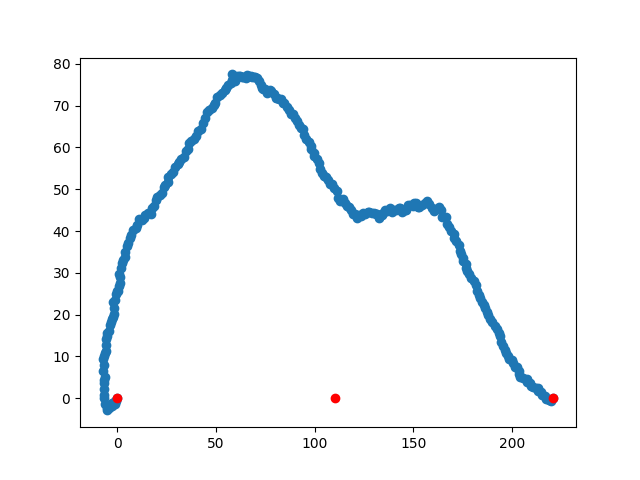

In [ ]:
%matplotlib widget
def calculate_view_angle(plane_normal):
    normal = np.array(plane_normal) / np.linalg.norm(plane_normal)
    azimuth = np.degrees(np.arctan2(normal[1], normal[0]))
    elevation = np.degrees(np.arcsin(normal[2]))
    return elevation, azimuth

def project_to_2d(points, normal):
    normal = normal / np.linalg.norm(normal)
    u = np.cross(normal, [1, 0, 0])
    if np.linalg.norm(u) < 1e-6:
        u = np.cross(normal, [0, 1, 0])
    v = np.cross(normal, u)
    
    u, v = u / np.linalg.norm(u), v / np.linalg.norm(v)
    return np.array([[np.dot(p, u), np.dot(p, v)] for p in points])

def calc_rot_matrix(points):
    first_point, last_point = points[0], points[-1]
    angle = np.arctan2(last_point[1] - first_point[1], last_point[0] - first_point[0])
    rotation_matrix = np.array([
        [np.cos(-angle), -np.sin(-angle)],
        [np.sin(-angle), np.cos(-angle)]
    ])
    return rotation_matrix
    
def apply_rotation(points, matrix: np.ndarray, center = None):
    if center is None:
        center = points[0]
    return (points - center) @ matrix.T

def get_values(image: np.ndarray, coords: np.ndarray):
    x_size, y_size, z_size = image.shape
    coords = np.clip(coords, [0, 0, 0], [x_size-1, y_size-1, z_size-1])
    result = image[coords[:, 0], coords[:, 1], coords[:, 2]]
    return result

fig = plt.figure()
ax = fig.add_subplot()

for i in range(1):
    ax.cla()
    rotated_plane = rotate_vector(flow_vector, plane_normal, i*rotation_degrees)
    
    first_to_last_vector = original_skeleton[-1] - original_skeleton[0]
    perpendicular_vector = np.cross(first_to_last_vector, rotated_plane)
    perpendicular_vector /= np.linalg.norm(perpendicular_vector)
    
    
    first_point_at_zero_skeleton = skeleton - skeleton[0]
    projected_points = project_to_2d(first_point_at_zero_skeleton, rotated_plane)
    rotation_matrix = calc_rot_matrix(projected_points)
    aligned_points = apply_rotation(projected_points, rotation_matrix)
    
    ax.scatter(*zip(*aligned_points))
    
    first_point = first_point_at_zero_skeleton[0]
    projected_first_point = project_to_2d([first_point_at_zero_skeleton[0]], rotated_plane)[0]
    ax.scatter(*projected_first_point, color='r')
    
    last_point = first_point_at_zero_skeleton[-1]
    projected_last_point = project_to_2d([last_point], rotated_plane)[0]
    rotated_last_point = apply_rotation(np.array([projected_first_point, projected_last_point]), rotation_matrix)
    ax.scatter(*rotated_last_point[1], color='r')
    
    middle_point = (first_point_at_zero_skeleton[0] + first_point_at_zero_skeleton[-1]) / 2
    projected_middle_point = project_to_2d([middle_point], rotated_plane)[0]
    rotated_middle_point = apply_rotation(np.array([projected_first_point, projected_middle_point]), rotation_matrix)
    ax.scatter(*rotated_middle_point[1], color='r')
    
    
    y_step = 0.5
    steps = np.arange(-200, 201, y_step)
    steps = np.array([(s*perpendicular_vector).astype(int) for s in steps])
    new_image = np.zeros((len(steps), len(original_skeleton)))
    for i, point in enumerate(original_skeleton):
        values = get_values(normalized_image, steps+point).astype(int)
        print(aligned_points[i].astype(int))
        
        # values = get_value(image, point).astype(int)
        # print(values)
        # new_image[:, i] = values
    
    
    ax.set_ylim([-100, 100])
    ax.set_xlim([-50, 250])
    ax.set_aspect('equal')
    # display(fig)
    # clear_output(wait = True)
    # time.sleep(0.1)

[array([ 22.,  64., -89.]), array([ 22.34223123,  64.30623046, -89.66148498]), array([ 22.68446245,  64.61246093, -90.32296996]), array([ 22.02488507,  64.91678379, -89.98627377]), array([ 22.3671163 ,  65.22301426, -90.64775875]), array([ 22.02947145,  65.86688956, -90.98731119]), array([ 22.37170268,  66.17312002, -91.64879617]), array([ 22.03405784,  66.81699533, -91.98834861]), array([ 22.37628907,  67.12322579, -92.64983359]), array([ 22.03864423,  67.7671011 , -92.98938603]), array([ 22.38087545,  68.07333156, -93.65087101]), array([ 21.041422  ,  68.71529927, -92.99224228]), array([ 19.70196855,  69.35726697, -92.33361355]), array([ 19.04239117,  69.66158984, -91.99691736]), array([ 18.04058256,  69.65968224, -90.99873618]), array([ 17.03877395,  69.65777464, -90.00055501]), array([ 16.37919656,  69.96209751, -89.66385882]), array([ 16.05726402,  69.62254507, -88.98761019]), array([ 14.71781057,  70.26451277, -88.32898146]), array([ 13.71600196,  70.26260518, -87.33080029]), arr

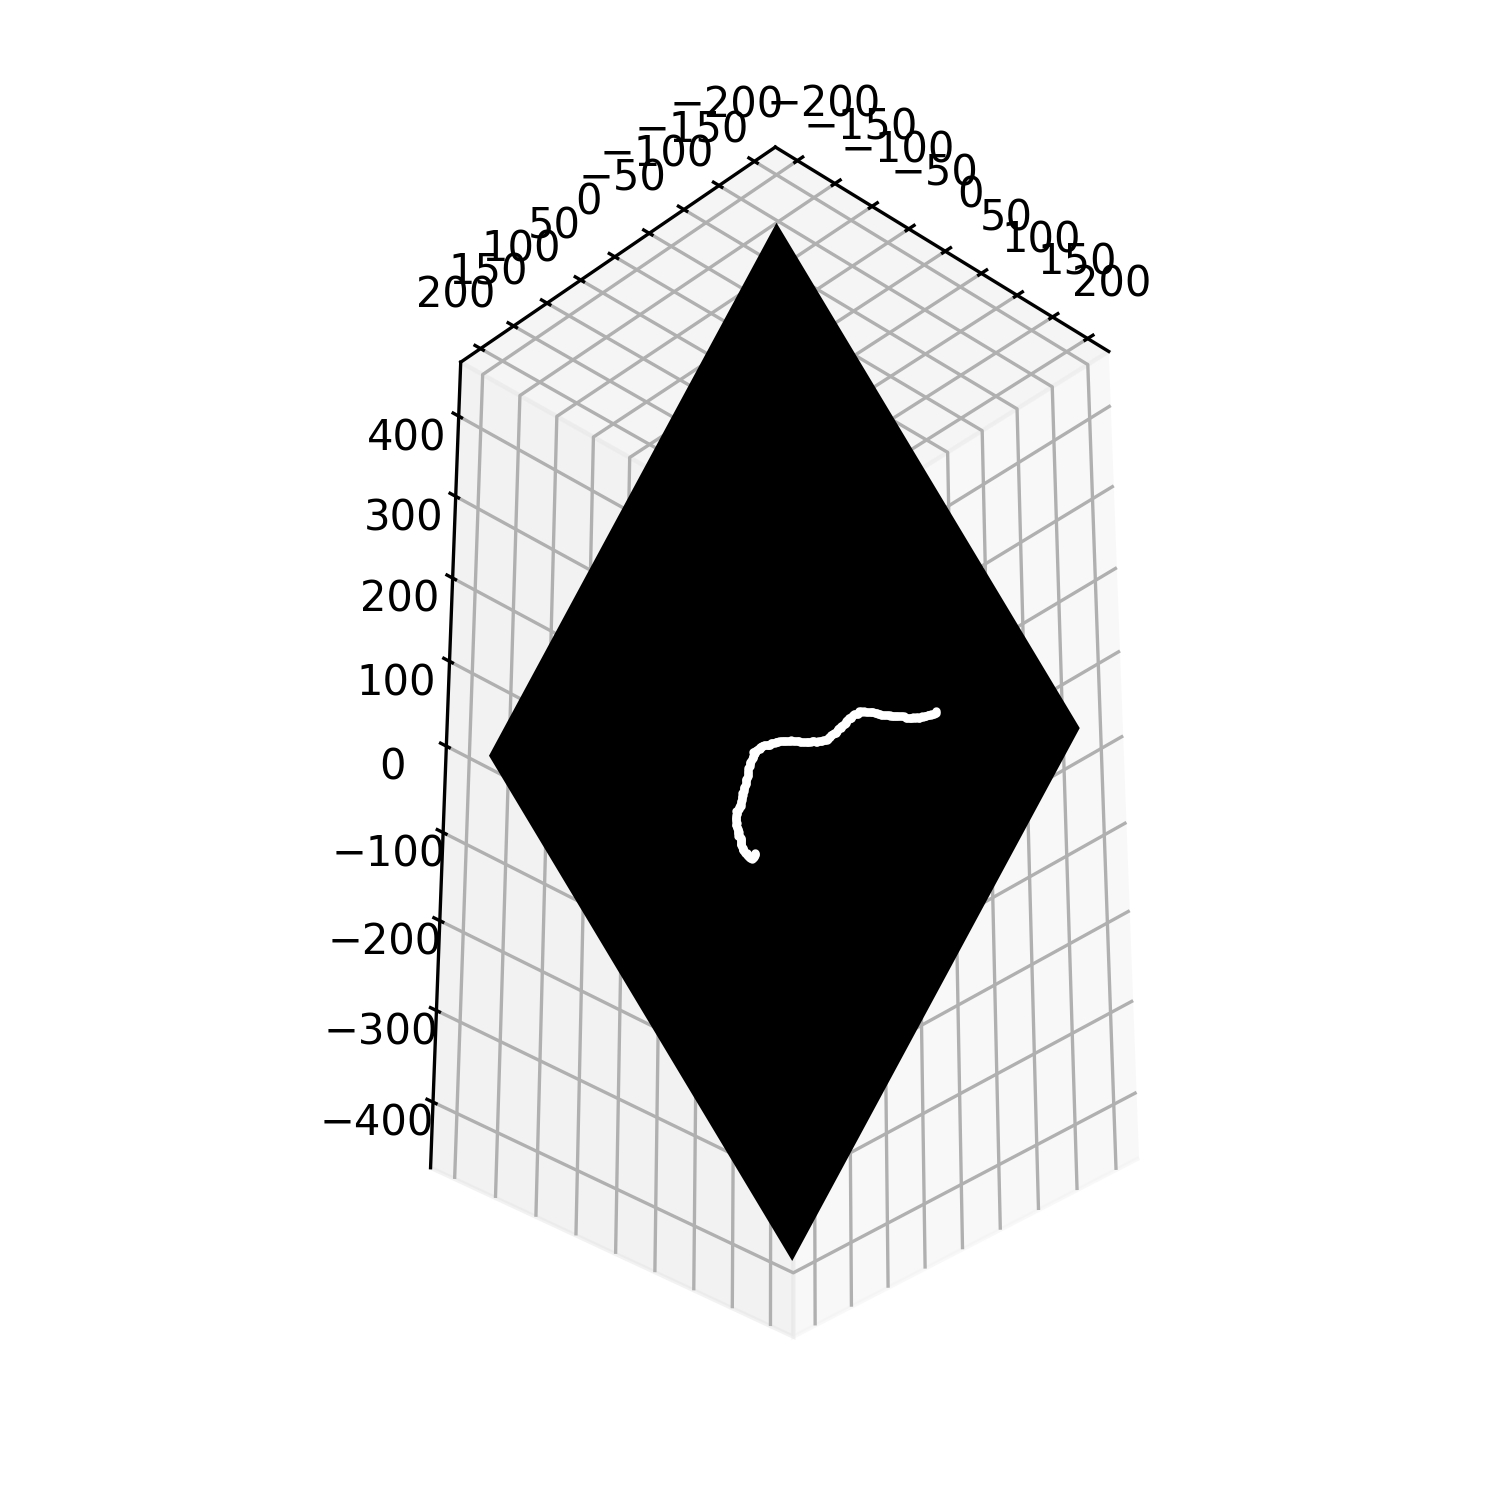

[array([ 23.78300265,  80.63294145, -20.07292794]), array([ 24.77647569,  81.57205395, -20.32524634]), array([ 25.76994873,  82.51116645, -20.57756474]), array([ 25.73962463,  83.22828465, -20.74982967]), array([ 26.73309767,  84.16739715, -21.00214806]), array([ 26.72720264,  85.11240468, -21.23003739]), array([ 27.72067567,  86.05151718, -21.48235579]), array([ 27.71478064,  86.99652472, -21.71024511]), array([ 28.70825368,  87.93563721, -21.96256351]), array([ 28.70235865,  88.88064475, -22.19045284]), array([ 29.69583169,  89.81975725, -22.44277123]), array([ 28.66613952,  90.54277048, -22.59060709]), array([ 27.63644734,  91.26578372, -22.73844295]), array([ 27.60612324,  91.98290192, -22.91070788]), array([ 26.58232611,  91.76090763, -22.83065441]), array([ 25.55852897,  91.53891333, -22.75060095]), array([ 25.52820487,  92.25603154, -22.92286587]), array([ 25.5037758 ,  92.02814221, -22.86724148]), array([ 24.47408363,  92.75115544, -23.01507733]), array([ 23.45028649,  92.52916

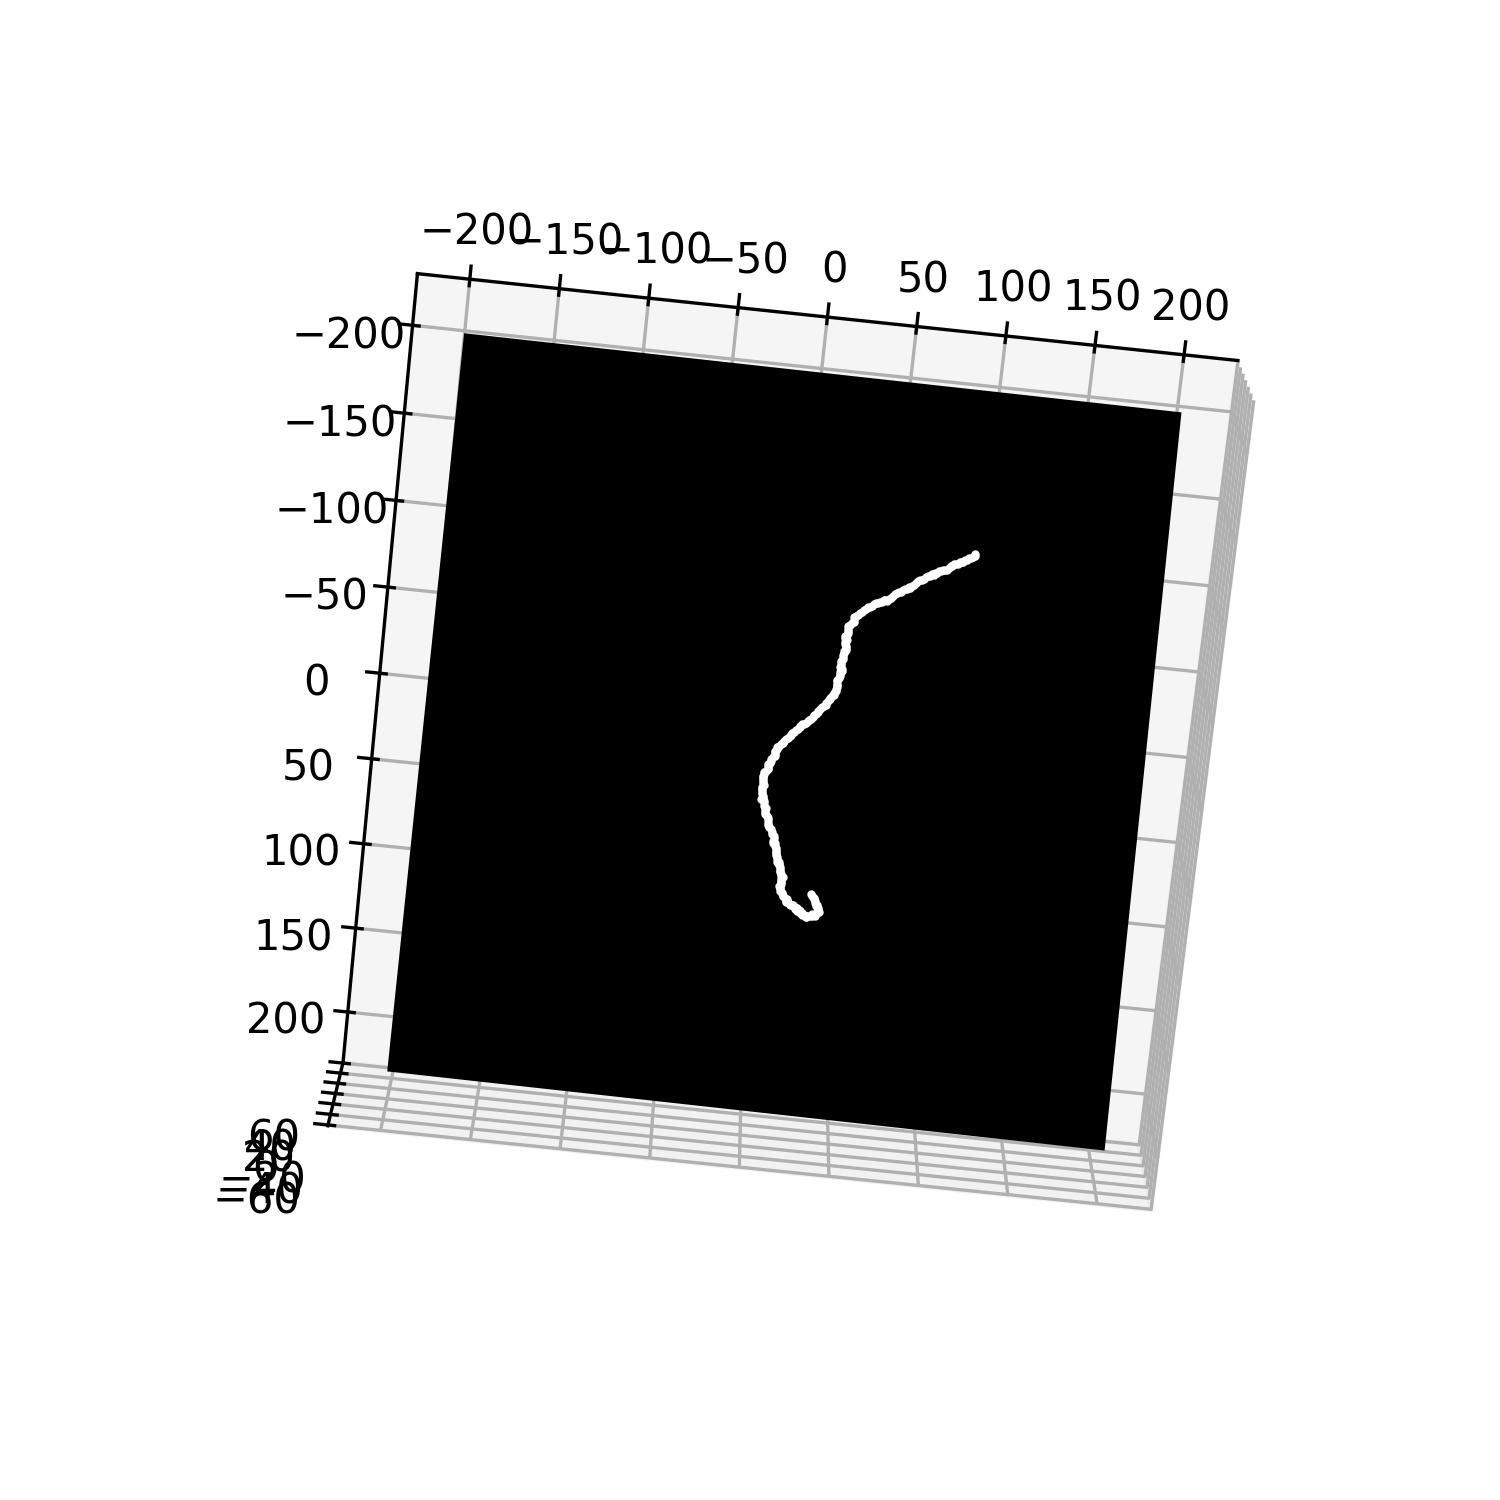

[array([-31.18734724,  37.40632638,  -8.21984884]), array([-30.60908552,  38.19545724,  -7.57931903]), array([-30.0308238 ,  38.9845881 ,  -6.93878921]), array([-29.74438334,  40.12780833,  -6.3738307 ]), array([-29.16612162,  40.91693919,  -5.73330088]), array([-29.30670105,  41.84664948,  -5.51979095]), array([-28.72843933,  42.63578034,  -4.87926113]), array([-28.86901875,  43.56549062,  -4.66575119]), array([-28.29075703,  44.35462148,  -4.02522137]), array([-28.43133646,  45.28433177,  -3.81171143]), array([-27.85307474,  46.07346263,  -3.17118161]), array([-28.28547543,  47.35726228,  -3.03324299]), array([-28.71787613,  48.64106194,  -2.89530436]), array([-28.43143567,  49.78428216,  -2.33034586]), array([-28.72325694,  50.13837153,  -2.40591717]), array([-29.01507821,  50.49246089,  -2.48148848]), array([-28.72863776,  51.63568112,  -1.91652998]), array([-28.30161788,  51.84919106,  -1.56508141]), array([-28.73401857,  53.13299071,  -1.42714279]), array([-29.02583984,  53.48708

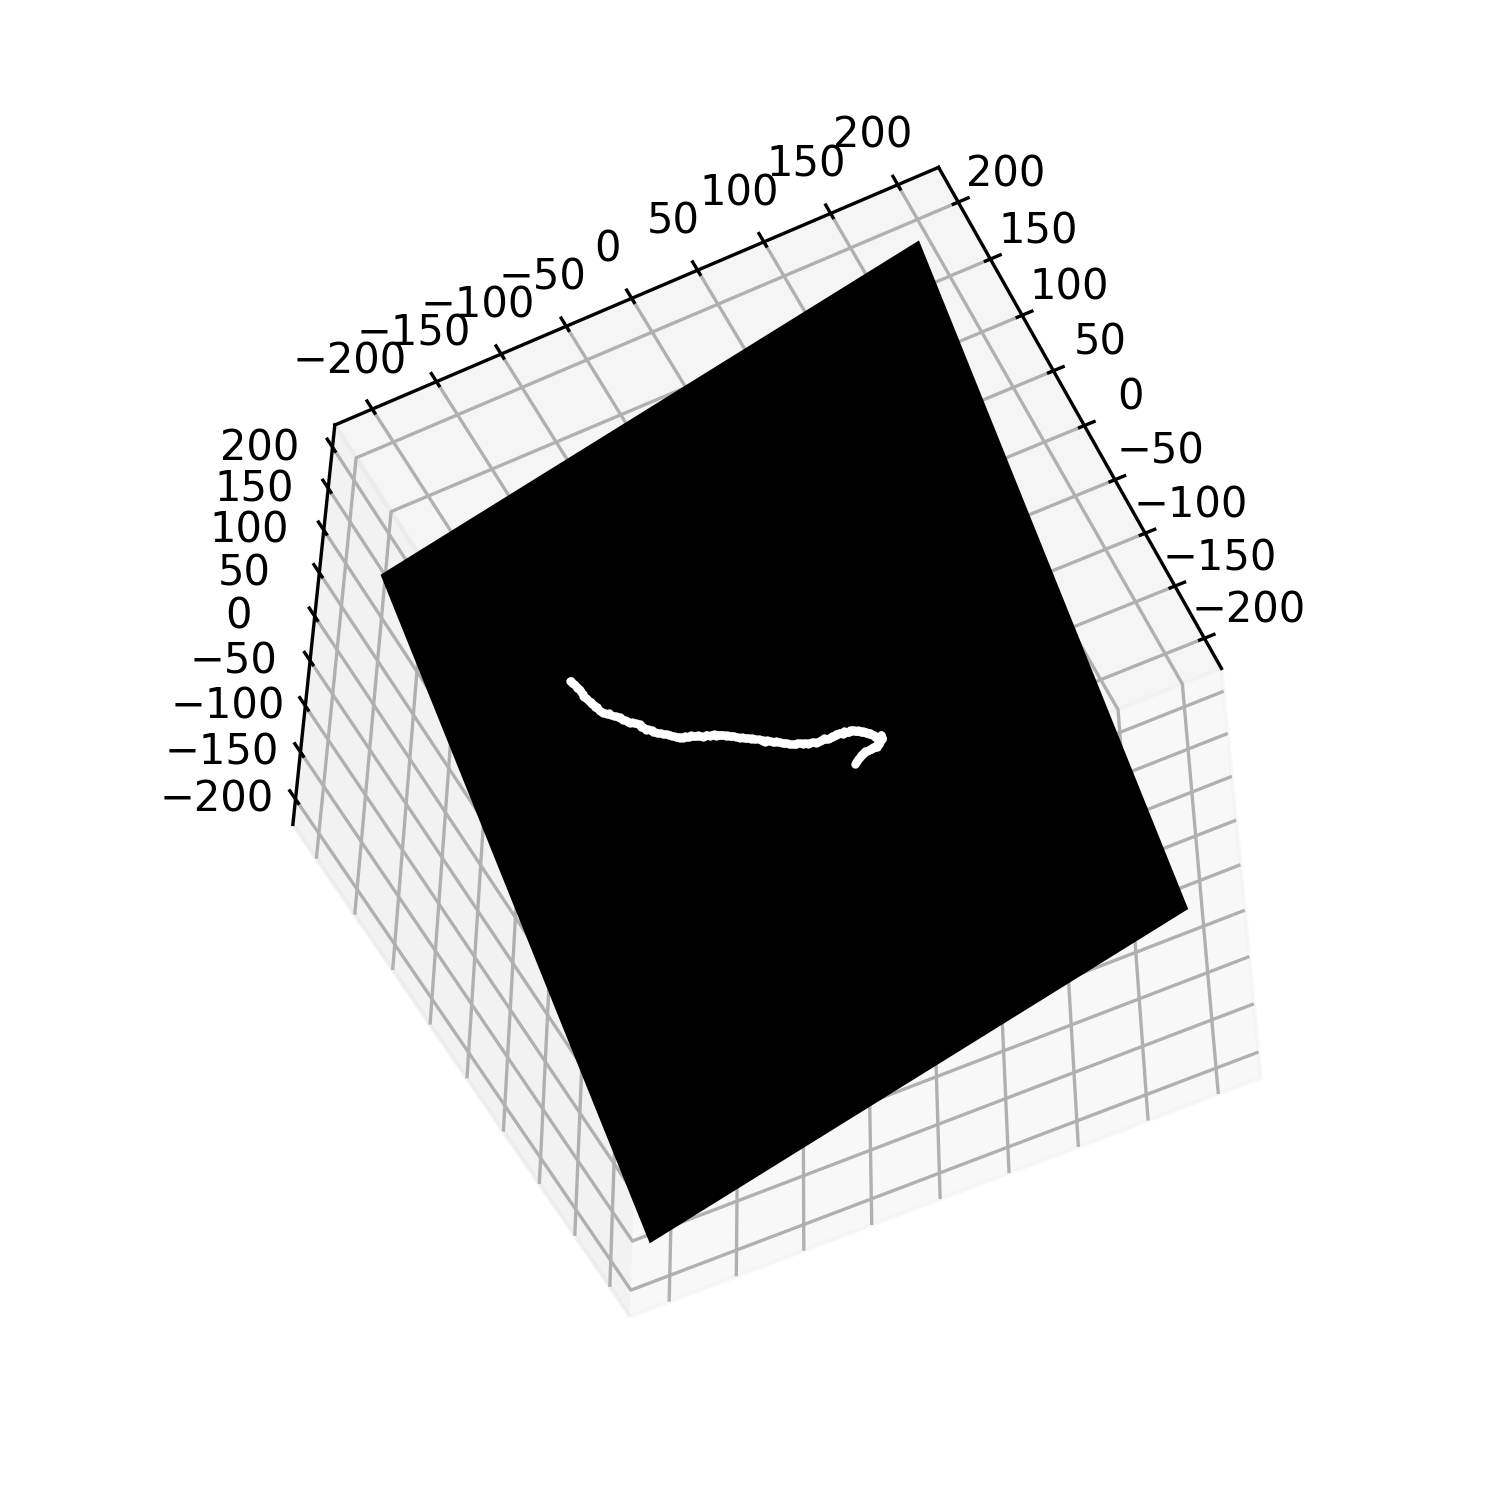

[array([-32.97034989,  20.77338493, -77.1469209 ]), array([-33.04332998,  20.92963376, -76.91555767]), array([-33.11631007,  21.08588258, -76.68419443]), array([-33.4591229 ,  21.81630747, -75.61027481]), array([-33.53210299,  21.97255629, -75.37891158]), array([-34.00443223,  22.60113435, -75.27706475]), array([-34.07741232,  22.75738318, -75.04570152]), array([-34.54974155,  23.38596124, -74.94385469]), array([-34.62272164,  23.54221006, -74.71249145]), array([-35.09505088,  24.17078812, -74.61064463]), array([-35.16803097,  24.32703695, -74.37928139]), array([-35.91019294,  25.52979107, -73.43487817]), array([-36.65235492,  26.73254519, -72.49047496]), array([-36.99516775,  27.46297008, -71.41655533]), array([-37.26500049,  28.03714614, -70.57399894]), array([-37.53483323,  28.6113222 , -69.73144255]), array([-37.87764606,  29.34174709, -68.65752293]), array([-37.74812965,  29.44359392, -67.68545013]), array([-38.49029163,  30.64634804, -66.74104691]), array([-38.76012437,  31.22052

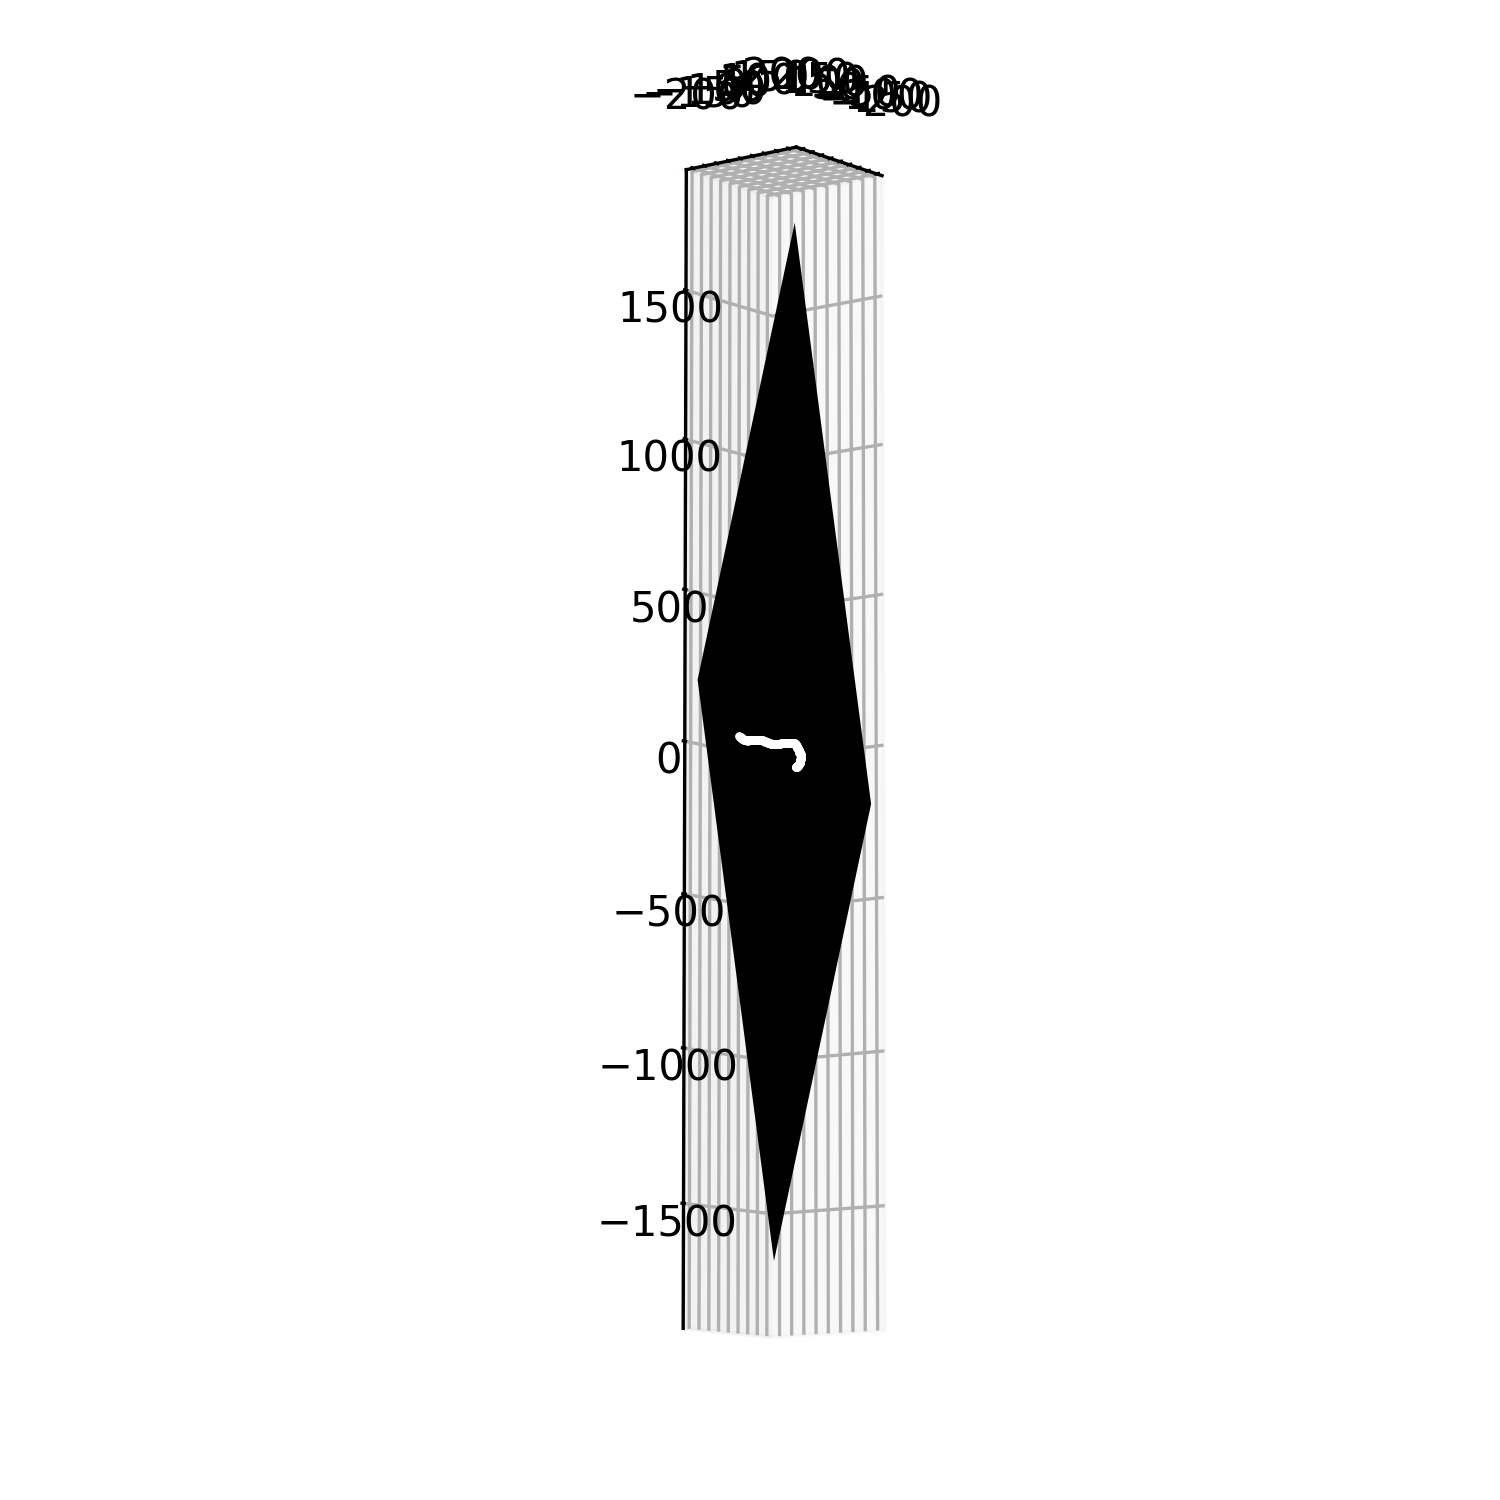

In [6]:
%matplotlib widget
def calculate_view_angle(plane_normal):
    normal = np.array(plane_normal) / np.linalg.norm(plane_normal)
    azimuth = np.degrees(np.arctan2(normal[1], normal[0]))
    elevation = np.degrees(np.arcsin(normal[2]))
    return elevation, azimuth

for i in range(rotations):
    fig = plt.figure(figsize=(5, 5), dpi=300)
    ax = fig.add_subplot(projection='3d')

    rotated_plane = rotate_vector(flow_vector, plane_normal, i*rotation_degrees)
    draw_surface(ax, rotated_plane)
    # draw_wireframe(ax, rotated_plane)
    
    projected_points = [project_point(rotated_plane, p) for p in skeleton]
    print(projected_points)
    
    for point in skeleton:
        # ax.scatter(*point)
        ax.scatter(*project_point(rotated_plane, point), c='w', s=1)
    
    center = project_point(rotated_plane, middle_point)
    elevation, azimuth = calculate_view_angle(rotated_plane)
    ax.view_init(elev=elevation, azim=azimuth)
        
    ax.set_aspect('equal')
    plt.show()